In [1]:
import polars as pl

import rustystats as rs

import matplotlib.pyplot as plt
import numpy as np

data = pl.read_parquet("https://raw.githubusercontent.com/PricingFrontier/pricing-data-example/917c853e256df8d5814721ab56f72889a908bb08/data/processed/severity_set.parquet")
data = data.filter(pl.col("ClaimAmount") > 0)

In [2]:
data.columns

['IDpol',
 'VehPower',
 'VehAge',
 'DrivAge',
 'BonusMalus',
 'VehBrand',
 'VehGas',
 'Area',
 'Density',
 'Region',
 'Group',
 'ClaimAmount']

In [3]:
exploration = rs.explore_data(
    data=data,
    response="ClaimAmount",
    categorical_factors=["Region", "Area", "VehBrand", "VehGas", "Region"],
    continuous_factors=["VehPower", "VehAge", "DrivAge", "BonusMalus" ]
)

In [4]:
data = data.with_columns([
    pl.col("Density").log().alias("log_Density"),
    pl.col("BonusMalus").log().alias("log_BonusMalus"),
])

formula = """
    ClaimAmount ~
    ns(VehPower, df=4) +
    ns(VehAge, df=4) +
    I(DrivAge ** 2) +
    bs(BonusMalus, df=4) +
    TE(VehBrand) +
    TE(VehGas) +
    TE(Area) +
    bs(Density, df=4) +
    TE(Region)
"""

model = rs.glm(
    formula=formula,
    data=data,
    family="gamma"
).fit(alpha=0.5, l1_ratio=0.5)

In [5]:
print(model.summary())

                                 GLM Results                                  

Family:              Gamma           No. Observations:         26444
Link Function:       (default)       Df Residuals:             26426
Method:              IRLS + Elasticnet Df Model:                    17
Scale:               1.2417          Alpha (λ):               0.5000
L1 Ratio:            0.50            Iterations:                  15
Non-zero coefs:      17             

Log-Likelihood:         -223983.1494 Deviance:                 32812.1009
AIC:                     448002.2988 Null Deviance:            33108.9443
BIC:                     448149.5890 Pearson chi2:              130929.53
Converged:           True           

------------------------------------------------------------------------------
Variable                  Coef    Std.Err        z    P>|z|                 95% CI     
------------------------------------------------------------------------------
Intercept               9.550

In [6]:
diagnostics = model.diagnostics(
    data,
    categorical_factors=["Region", "Area", "VehBrand", "VehGas"],
    continuous_factors=["VehPower", "VehAge", "DrivAge", "BonusMalus", "Density"]
)

In [7]:
# Predict on the data
predictions = model.predict(data)
print(f"Predictions shape: {predictions.shape}")
print(f"Mean predicted claim amounts: {predictions.mean():.6f}")
print(f"Min: {predictions.min():.6f}, Max: {predictions.max():.6f}")

plot_data = data.with_columns([
    pl.lit(predictions).alias("Predicted"),
    pl.col("ClaimAmount").alias("Actual")
])

Predictions shape: (26444,)
Mean predicted claim amounts: 1746.770018
Min: 1024.897294, Max: 2652.390628


In [8]:
def plot_ae_chart(
    data: pl.DataFrame,
    factor: str,
    bins: list = None,
    figsize: tuple = (12, 4),
    title: str = None,
):
    """
    Plot Actual vs Expected chart for severity modeling.
    
    For severity: compares sum of actual claim amounts vs sum of predicted amounts.
    A/E = sum(Actual) / sum(Predicted) for each group.
    
    Parameters
    ----------
    data : pl.DataFrame
        Data with 'Actual' and 'Predicted' columns (claim amounts).
    factor : str
        Column name to group by.
    bins : list, optional
        For continuous factors, bin edges. If None, treats factor as categorical.
    figsize : tuple
        Figure size.
    title : str, optional
        Custom title. Defaults to factor name.
    """
    # Bin continuous factors if bins provided
    if bins is not None:
        bin_col = f"{factor}_bin"
        grouped = data.with_columns([
            pl.col(factor).cut(bins).alias(bin_col)
        ]).group_by(bin_col).agg([
            pl.col("Actual").sum().alias("Actual"),
            pl.col("Predicted").sum().alias("Expected"),
            pl.len().alias("Count")
        ])
        
        # Create proper sort order based on bin edges
        bin_labels = grouped[bin_col].to_list()
        def get_bin_lower(label):
            if label is None:
                return float('inf')
            s = str(label)
            try:
                lower = s.split(',')[0].strip('([')
                if lower == '-inf':
                    return float('-inf')
                return float(lower)
            except:
                return float('inf')
        
        sort_order = sorted(range(len(bin_labels)), key=lambda i: get_bin_lower(bin_labels[i]))
        grouped = grouped[sort_order]
        labels = [str(b) for b in grouped[bin_col].to_list()]
    else:
        grouped = data.group_by(factor).agg([
            pl.col("Actual").sum().alias("Actual"),
            pl.col("Predicted").sum().alias("Expected"),
            pl.len().alias("Count")
        ]).sort(factor)
        labels = [str(v) for v in grouped[factor].to_list()]
    
    # Calculate A/E and average amounts
    grouped = grouped.with_columns([
        (pl.col("Actual") / pl.col("Expected")).alias("A/E"),
        (pl.col("Actual") / pl.col("Count")).alias("Avg_Actual"),
        (pl.col("Expected") / pl.col("Count")).alias("Avg_Expected")
    ])
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    x = np.arange(len(labels))
    
    # Left: Count bar with Average Actual/Expected lines
    ax1 = axes[0]
    ax2 = ax1.twinx()
    
    ax1.bar(x, grouped["Count"].to_numpy(), alpha=0.3, color="gray", label="Claim Count")
    ax1.set_ylabel("Claim Count", color="gray")
    ax1.tick_params(axis="y", labelcolor="gray")
    ax1.set_ylim(bottom=0)
    
    y_actual = grouped["Avg_Actual"].to_numpy()
    y_expected = grouped["Avg_Expected"].to_numpy()
    
    ax2.plot(x, y_actual, "o-", color="steelblue", linewidth=2, markersize=8, label="Actual Avg")
    ax2.plot(x, y_expected, "s--", color="coral", linewidth=2, markersize=8, label="Expected Avg")
    ax2.set_ylabel("Average Claim Amount", color="black")
    ax2.set_ylim(bottom=0)
    
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=45 if bins else 0, ha="right" if bins else "center")
    ax1.set_xlabel(title or factor)
    ax1.set_title(f"Average Severity by {title or factor}")
    ax2.legend(loc="upper left")
    
    # Right: A/E ratio
    ae_vals = grouped["A/E"].to_numpy()
    colors = ["green" if 0.95 <= v <= 1.05 else "orange" if 0.9 <= v <= 1.1 else "teal" for v in ae_vals]
    axes[1].bar(labels, ae_vals, color=colors)
    axes[1].axhline(y=1.0, color="red", linestyle="--", label="Perfect calibration")
    axes[1].set_xticks(range(len(labels)))
    axes[1].set_xticklabels(labels, rotation=45 if bins else 0, ha="right" if bins else "center")
    axes[1].set_xlabel(title or factor)
    axes[1].set_ylabel("A/E Ratio")
    axes[1].set_title(f"A/E Ratio by {title or factor}")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    return grouped

In [9]:
print(formula)


    ClaimAmount ~
    ns(VehPower, df=4) +
    ns(VehAge, df=4) +
    I(DrivAge ** 2) +
    bs(BonusMalus, df=4) +
    TE(VehBrand) +
    TE(VehGas) +
    TE(Area) +
    bs(Density, df=4) +
    TE(Region)



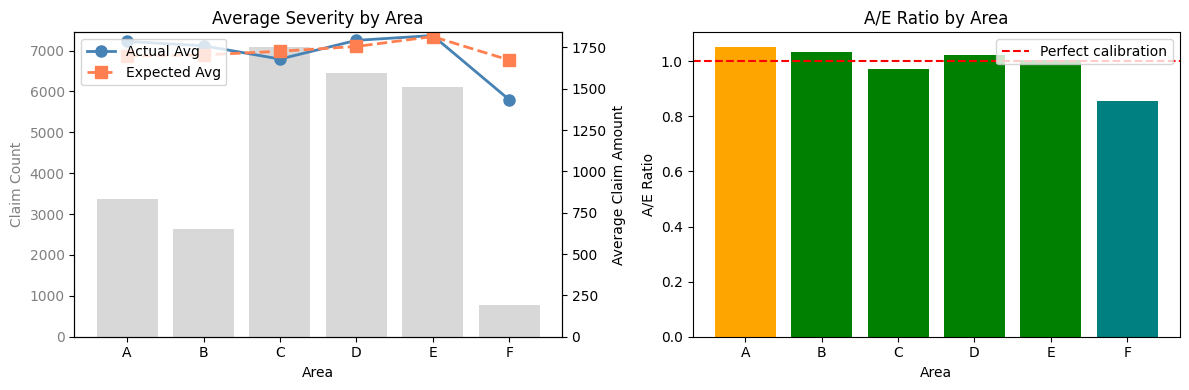

Area,Actual,Expected,Count,A/E,Avg_Actual,Avg_Expected
str,f64,f64,u32,f64,f64,f64
"""A""",6.0077e6,5.7089e6,3364,1.05234,1785.883237,1697.058803
"""B""",4.6340e6,4.4881e6,2633,1.032517,1759.98755,1704.560958
"""C""",1.1912e7,1.2248e7,7093,0.972568,1679.375965,1726.744137
"""D""",1.1576e7,1.1337e7,6458,1.021079,1792.498984,1755.49574
"""E""",1.1152e7,1.1115e7,6122,1.003404,1821.70088,1815.521349
"""F""",1.1099e6,1.2952e6,774,0.856961,1433.984302,1673.336165


In [10]:
plot_ae_chart(plot_data, "Area")

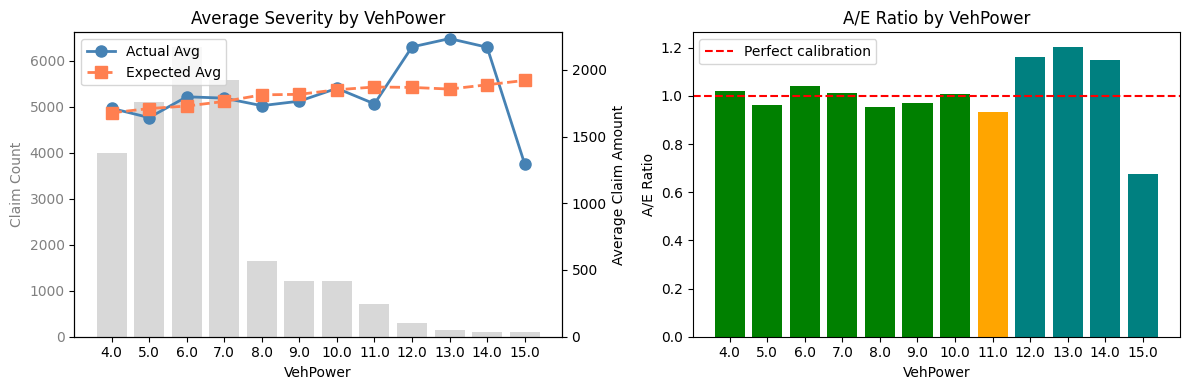

VehPower,Actual,Expected,Count,A/E,Avg_Actual,Avg_Expected
f64,f64,f64,u32,f64,f64,f64
4.0,6.8502e6,6.7160e6,4003,1.019986,1711.275703,1677.744946
5.0,8.3980e6,8.7453e6,5115,0.960283,1641.834035,1709.738901
6.0,1.1335e7,1.0899e7,6305,1.040056,1797.789301,1728.549711
7.0,9.9996e6,9.8606e6,5593,1.014093,1787.876649,1763.030012
8.0,2.8481e6,2.9814e6,1645,0.955282,1731.368638,1812.4167
…,…,…,…,…,…,…
11.0,1.2458e6,1.3360e6,714,0.93249,1744.836499,1871.158461
12.0,642786.11,552950.041075,296,1.162467,2171.574696,1868.074463
13.0,310503.58,257941.240191,139,1.203776,2233.838705,1855.692375


In [11]:
plot_ae_chart(plot_data, "VehPower")

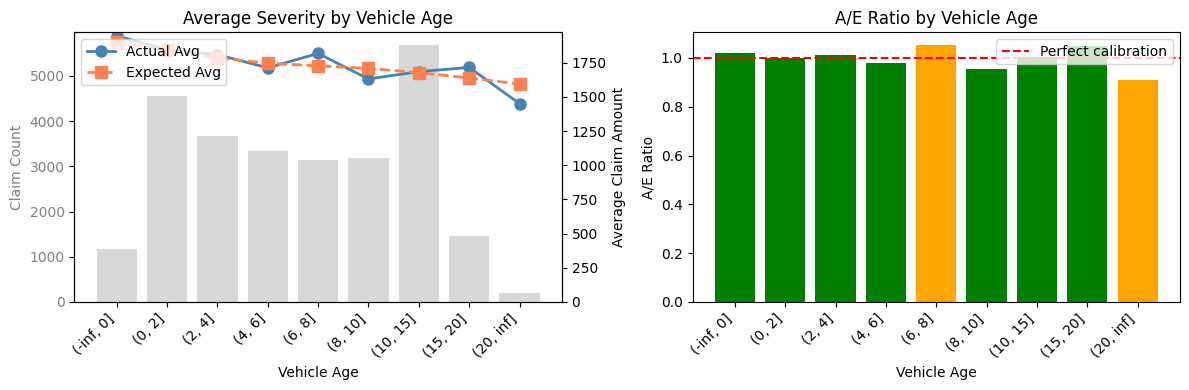

VehAge_bin,Actual,Expected,Count,A/E,Avg_Actual,Avg_Expected
cat,f64,f64,u32,f64,f64,f64
"""(-inf, 0]""",2.3001e6,2.2496e6,1181,1.022474,1947.60663,1904.797545
"""(0, 2]""",8.4248e6,8.4131e6,4566,1.001395,1845.119021,1842.549232
"""(2, 4]""",6.6319e6,6.5409e6,3666,1.013913,1809.015971,1784.192972
"""(4, 6]""",5.7369e6,5.8506e6,3349,0.980565,1713.013503,1746.965317
"""(6, 8]""",5.7196e6,5.4341e6,3146,1.052548,1818.055445,1727.290183
"""(8, 10]""",5.2073e6,5.4540e6,3192,0.954763,1631.361037,1708.655253
"""(10, 15]""",9.5715e6,9.5329e6,5680,1.004043,1685.121757,1678.336044
"""(15, 20]""",2.4995e6,2.3865e6,1457,1.04736,1715.492677,1637.921217
"""(20, inf]""",300344.31,330019.958879,207,0.910079,1450.938696,1594.299318


In [12]:
plot_ae_chart(plot_data, "VehAge", bins=[0, 2, 4, 6, 8, 10, 15, 20], title="Vehicle Age")

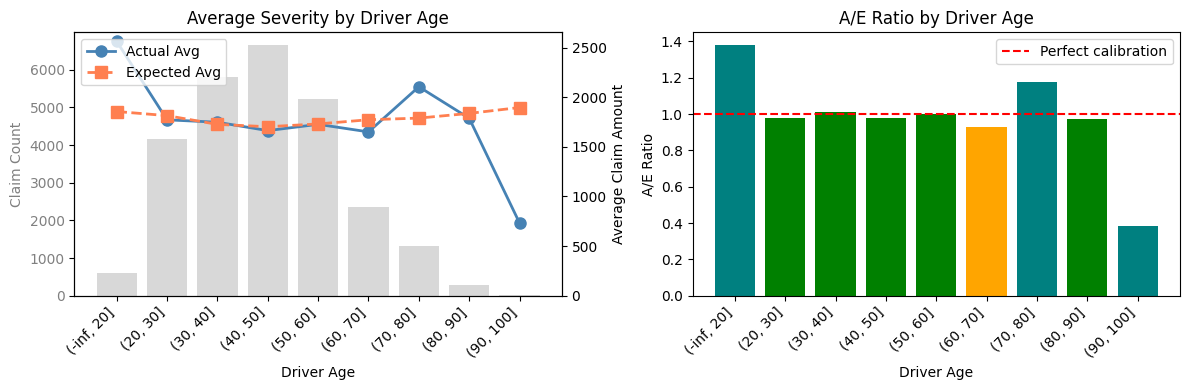

DrivAge_bin,Actual,Expected,Count,A/E,Avg_Actual,Avg_Expected
cat,f64,f64,u32,f64,f64,f64
"""(-inf, 20]""",1.5808e6,1.1451e6,617,1.38058,2562.152431,1855.851896
"""(20, 30]""",7.3815e6,7.5575e6,4165,0.976711,1772.272898,1814.531737
"""(30, 40]""",1.0138e7,1.0012e7,5800,1.012563,1747.970564,1726.283158
"""(40, 50]""",1.1080e7,1.1340e7,6660,0.977026,1663.618248,1702.736236
"""(50, 60]""",9.0363e6,9.0576e6,5233,0.997643,1726.788792,1730.868559
"""(60, 70]""",3.8940e6,4.1828e6,2359,0.930965,1650.713056,1773.121259
"""(70, 80]""",2.7831e6,2.3659e6,1322,1.176365,2105.255234,1789.627557
"""(80, 90]""",486408.75,499679.364105,272,0.973442,1788.267463,1837.056486
"""(90, 100]""",11721.74,30340.189503,16,0.386344,732.60875,1896.261844


In [13]:
plot_ae_chart(plot_data, "DrivAge", bins=[20,30,40,50,60,70,80,90,100], title="Driver Age")

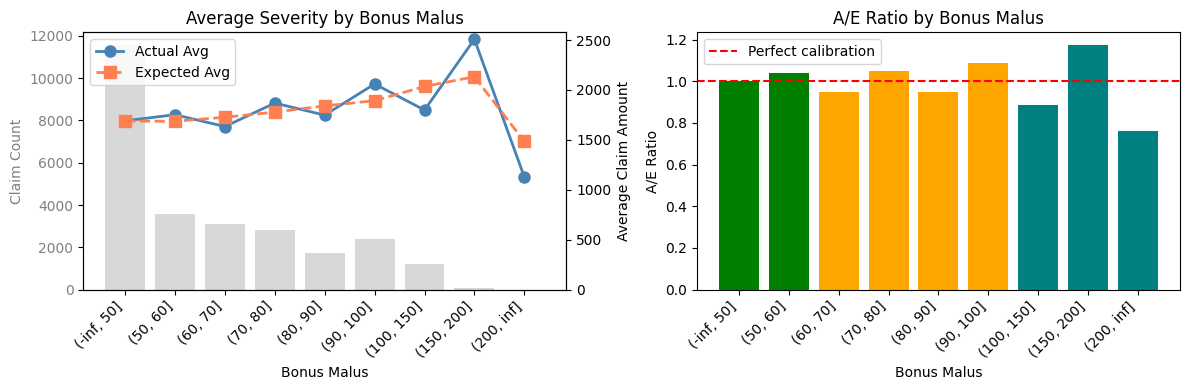

BonusMalus_bin,Actual,Expected,Count,A/E,Avg_Actual,Avg_Expected
cat,f64,f64,u32,f64,f64,f64
"""(-inf, 50]""",1.9595e7,1.9567e7,11592,1.001427,1690.390947,1687.98229
"""(50, 60]""",6.2655e6,6.0316e6,3576,1.038778,1752.08851,1686.681884
"""(60, 70]""",5.0895e6,5.3787e6,3116,0.946231,1633.343212,1726.156124
"""(70, 80]""",5.2275e6,4.9751e6,2798,1.050729,1868.28124,1778.08138
"""(80, 90]""",3.0058e6,3.1646e6,1720,0.949824,1747.542959,1839.860522
"""(90, 100]""",4.9143e6,4.5151e6,2386,1.088396,2059.624795,1892.347942
"""(100, 150]""",2.1617e6,2.4456e6,1202,0.883937,1798.455441,2034.596448
"""(150, 200]""",130420.29,110891.461487,52,1.176108,2508.0825,2132.528106
"""(200, inf]""",2256.12,2968.373231,2,0.760053,1128.06,1484.186615


In [14]:
plot_ae_chart(plot_data, "BonusMalus", bins=[50,60,70,80,90,100,150,200], title="Bonus Malus")

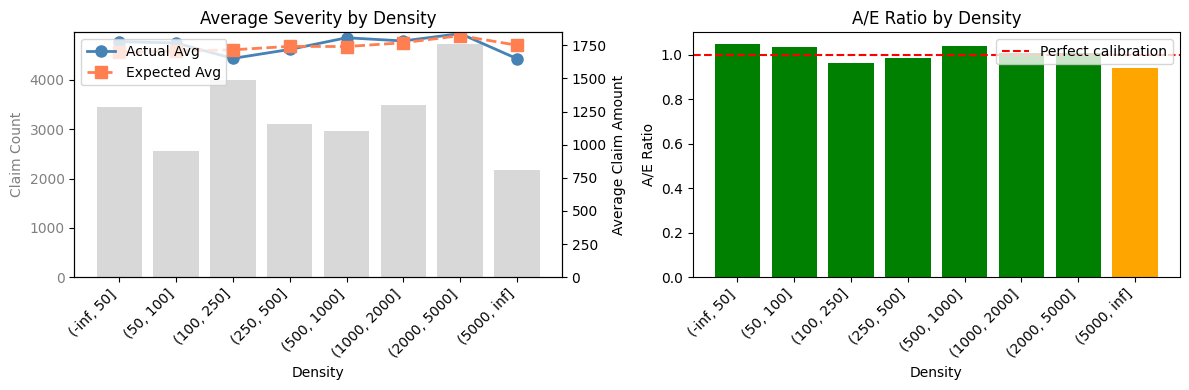

Density_bin,Actual,Expected,Count,A/E,Avg_Actual,Avg_Expected
cat,f64,f64,u32,f64,f64,f64
"""(-inf, 50]""",6.1338e6,5.8556e6,3451,1.047506,1777.402524,1696.79384
"""(50, 100]""",4.5151e6,4.3583e6,2556,1.035997,1766.487128,1705.108587
"""(100, 250]""",6.5892e6,6.8479e6,3992,0.962225,1650.60976,1715.409226
"""(250, 500]""",5.3213e6,5.3932e6,3097,0.986666,1718.219138,1741.439391
"""(500, 1000]""",5.3576e6,5.1607e6,2966,1.03815,1806.328233,1739.948581
"""(1000, 2000]""",6.2124e6,6.1661e6,3486,1.007521,1782.11274,1768.809657
"""(2000, 5000]""",8.6869e6,8.6139e6,4727,1.008472,1837.72074,1822.282631
"""(5000, inf]""",3.5755e6,3.7959e6,2169,0.941936,1648.43278,1750.047898


In [15]:
plot_ae_chart(plot_data, "Density", bins=[50, 100, 250, 500, 1000, 2000, 5000], title="Density")

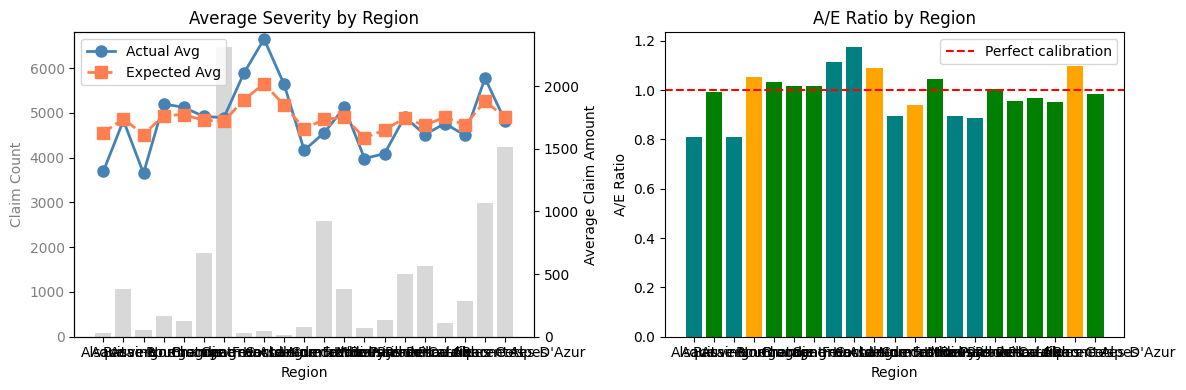

Region,Actual,Expected,Count,A/E,Avg_Actual,Avg_Expected
str,f64,f64,u32,f64,f64,f64
"""Alsace""",121424.99,149804.277484,92,0.810558,1319.836848,1628.307364
"""Aquitaine""",1.8220e6,1.8368e6,1055,0.991949,1726.985365,1741.002427
"""Auvergne""",183974.83,227442.574841,141,0.808885,1304.786028,1613.067907
"""Basse-Normandie""",839799.44,798281.146079,452,1.05201,1857.963363,1766.10873
"""Bourgogne""",631897.92,611908.918419,345,1.032667,1831.588174,1773.649039
…,…,…,…,…,…,…
"""Pays-de-la-Loire""",2.5425e6,2.6588e6,1576,0.956273,1613.28703,1687.056613
"""Picardie""",534452.87,550948.715683,314,0.970059,1702.079204,1754.613744
"""Poitou-Charentes""",1287120.9,1.3507e6,800,0.952894,1608.901125,1688.436163


In [16]:
plot_ae_chart(plot_data, "Region")

In [18]:
model.diagnostics(
    data,
    categorical_factors=["Region", "Area", "VehBrand", "VehGas", "Region"],
    continuous_factors=["VehPower", "VehAge", "DrivAge", "BonusMalus" ]
)

ModelDiagnostics(model_summary={'formula': '\n    ClaimAmount ~\n    ns(VehPower, df=4) +\n    ns(VehAge, df=4) +\n    I(DrivAge ** 2) +\n    bs(BonusMalus, df=4) +\n    TE(VehBrand) +\n    TE(VehGas) +\n    TE(Area) +\n    bs(Density, df=4) +\n    TE(Region)\n', 'family': 'gamma', 'link': 'log', 'n_observations': 26444, 'n_parameters': 18, 'degrees_of_freedom_residual': 26426, 'converged': True, 'iterations': 15}, convergence_details=ConvergenceDetails(max_iterations_allowed=25, iterations_used=15, converged=True, reason='converged'), fit_statistics={'deviance': 32812.100860293205, 'null_deviance': 33108.94425936251, 'deviance_explained': 0.008965655828345187, 'log_likelihood': -618793.9394263122, 'aic': 1237623.8788526244, 'bic': 1237771.1689748566, 'pearson_chi2': 130929.52706542396, 'dispersion_deviance': 1.241659761609521, 'dispersion_pearson': 4.954572279778398}, loss_metrics={'family_deviance_loss': 1.240814584037707, 'mse': 15489166.934821524, 'mae': 1399.3178909020232, 'rmse':